In [3]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import os
import zernike
import hamaker
import parallelize
import time

# Single frequency

In [7]:
ms_path = "/home/sleepypanda/Desktop/CASSA IUB Chronos/Codes/Everybeam/synthms_hba_dec60_t201411041558_SBH51.MS"
dout = "/home/sleepypanda/Desktop/CASSA IUB Chronos/Codes/Everybeam/output/"

npix = 2049
f = 130
time = 4.92183348e09
station = 0

J = hamaker.allsky_beam(ms_path, time, f*1e6, station_id=station, npix=npix)

np.save(dout + 'beam_%i.npy'%(f), J)

/tmp/ipykernel_4827/3093841609.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(20*np.log10(np.abs(J[:,:,0,0])), extent=(-90,90,-90,90), vmin=-100, vmax=0)


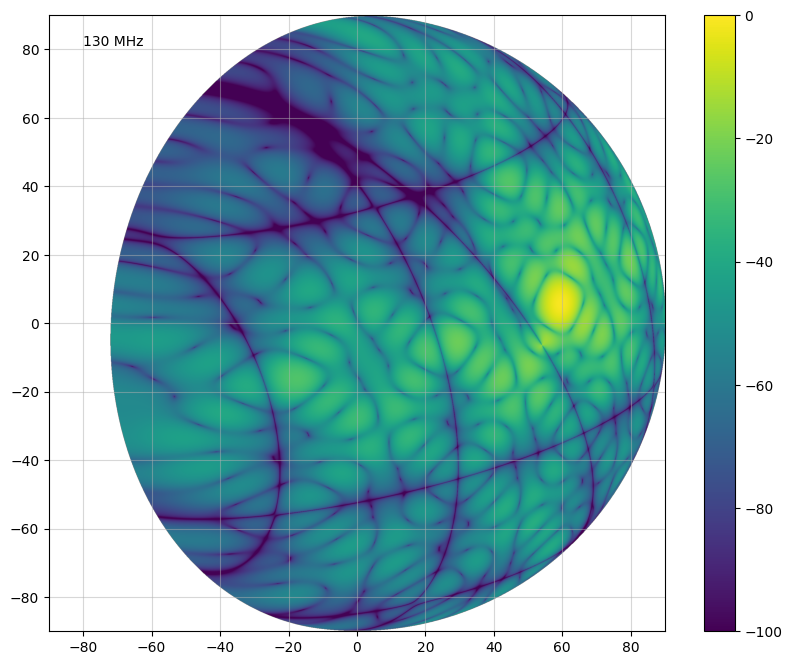

In [8]:
plt.figure(figsize=(10,8))

f = 130
dout = "/home/sleepypanda/Desktop/CASSA IUB Chronos/Codes/Everybeam/output/"
J = np.load(dout + 'beam_HBA_%i.npy'%f)

plt.imshow(20*np.log10(np.abs(J[:,:,0,0])), extent=(-90,90,-90,90), vmin=-100, vmax=0)
plt.colorbar()
plt.grid(alpha=0.5)
plt.text(-80, 81, "%i MHz"%f);


In [9]:
J[np.isnan(J)] = 0
cent = np.where(np.abs(J[:,:,0,0,])==np.abs(J[:,:,0,0,]).max())
cx, cy = cent[1][0], cent[0][0]
print(cx, cy)

px = 180. / J.shape[0]
r = int(15. / px)

Jz = J[cy-r:cy+r, cx-r:cx+r, :, :]

Jza_db = 20*np.log10(np.abs(Jz))

1700 959


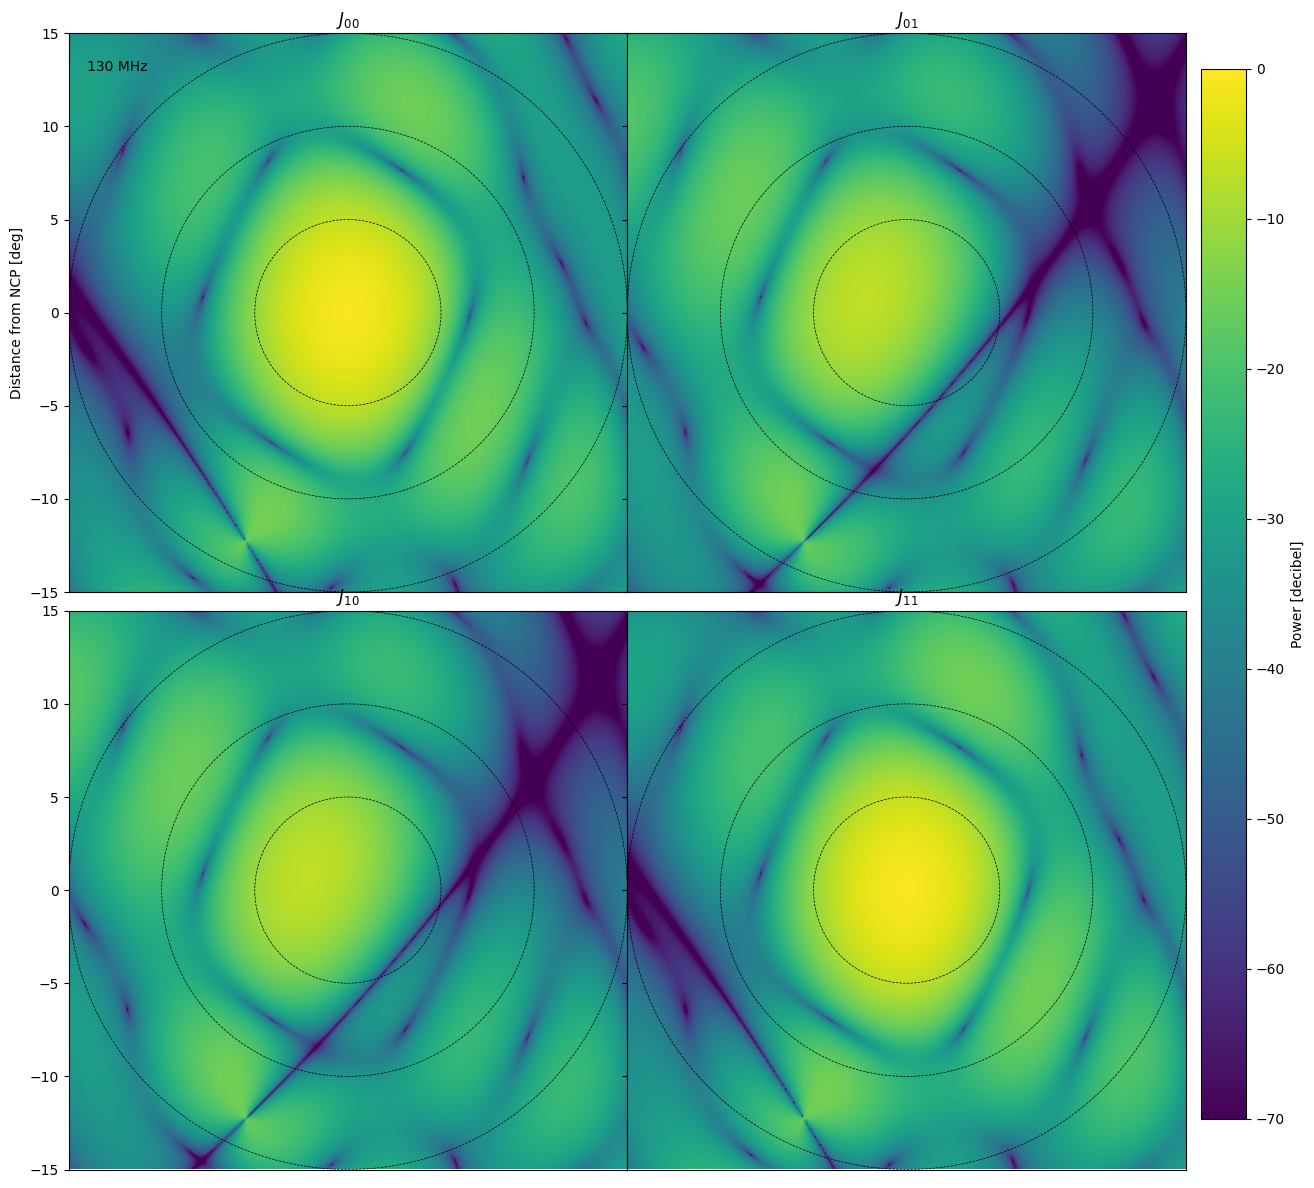

In [10]:
fig = plt.figure(figsize=(15,15), constrained_layout=False)
gs = fig.add_gridspec(2, 2, wspace=0.0, hspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

radii = [5, 10, 15]

for i in range(2):
    for j in range(2):
        im = ax[i,j].imshow(Jza_db[:,:,j,i], extent=(-15,15,-15,15), vmin=-70, vmax=0)
        ax[i,j].set_xticks([])
        ax[i,j].set_title("$J_{%i%i}$"%(i,j))
        for rad in radii: ax[i,j].add_patch(plt.Circle((0, 0), rad, fill=None, color='k', linestyle='--', linewidth=0.5))

fig.subplots_adjust(right=0.87)
cax = fig.add_axes([0.88, 0.15, 0.03, 0.7])
cb = fig.colorbar(im, cax=cax)
cb.ax.set_ylabel('Power [decibel]')
ax[0,0].set_ylabel('Distance from NCP [deg]')
ax[0,0].text(-14, 13, "%i MHz"%f);


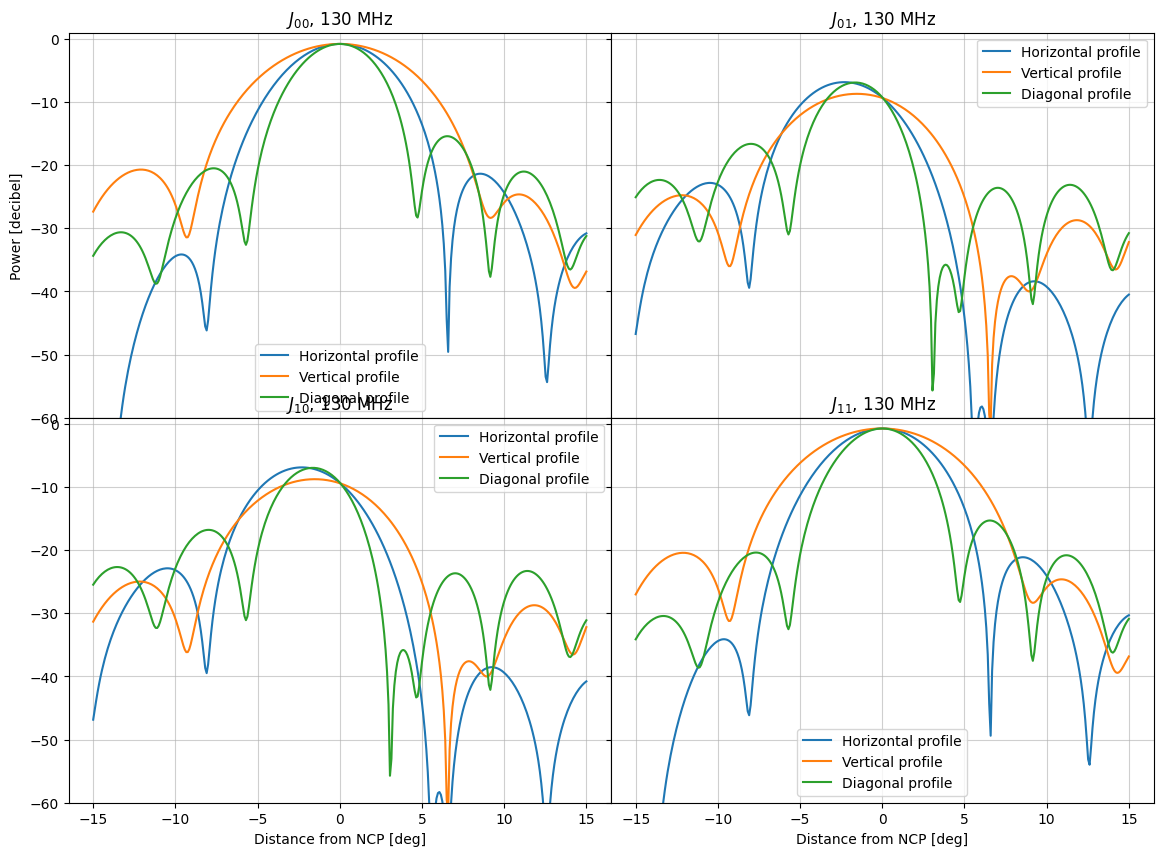

In [27]:
fig = plt.figure(figsize=(14,10), constrained_layout=False)
gs = fig.add_gridspec(2, 2, wspace=0.0, hspace=0.0)
ax = gs.subplots(sharex=True, sharey=True)

x = np.linspace(-15,15,r*2)

for i in range(2):
    for j in range(2):
        ax[i,j].plot(x, Jza_db[r,:,j,i], label='Horizontal profile')
        ax[i,j].plot(x, Jza_db[:,r,j,i], label='Vertical profile')
        ax[i,j].plot(x, np.diagonal(Jza_db[:,:,i,j]), label='Diagonal profile')
        ax[i,j].set_title("$J_{%i%i}$, %i MHz"%(i,j,f))
        ax[i,j].set_xlabel('Distance from NCP [deg]')
        ax[i,j].set_ylim([-60,1])
        # ax[i].set_xlim([-15,15])
        ax[i,j].grid(alpha=.6)
        ax[i,j].legend();

ax[0,0].set_ylabel('Power [decibel]');


In [28]:
import zernike

from mpl_toolkits.axes_grid1 import make_axes_locatable

def zernike_decom_recon(data, r=0, c=0, modes=200, thresh=35):
    Cr = zernike.decompose(data.real, modes)
    Ci = zernike.decompose(data.imag, modes)
    Mr = zernike.reconstruct(Cr, thresh, data)
    Mi = zernike.reconstruct(Ci, thresh, data)
    mod = np.abs(Mr+1j*Mi)
    
    rho, phi, mask = zernike.unit_disk(mod.shape[0])

    dat = np.abs(data)*mask
    
    res = np.abs(dat-mod)*mask

    fig = plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = fig.add_gridspec(1, 3, wspace=0.0, hspace=0.0)
    ax = gs.subplots(sharex=True, sharey=True)

    imgs = 20*np.log10(np.array([dat, mod, res]))
    
    labels = ['Hamaker', 'Zernike', 'Residual']

    for i in range(3):
        ax[i].axis('off')
        im = ax[i].imshow(imgs[i,...], vmin=-70, vmax=0)
        div = make_axes_locatable(ax[i])
        cax = div.new_vertical(size='5%', pad=0.3)
        fig.add_axes(cax)
        cb = fig.colorbar(im, cax=cax, orientation="horizontal")
        cb.ax.set_xlabel("%s $J_{%i%i}$"%(labels[i],r,c))
        cb.ax.xaxis.set_label_position('top')  
    
    return Cr, Ci, dat, mod, res


/tmp/ipykernel_3737/2939399235.py:22: RuntimeWarning: divide by zero encountered in log10
  imgs = 20*np.log10(np.array([dat, mod, res]))


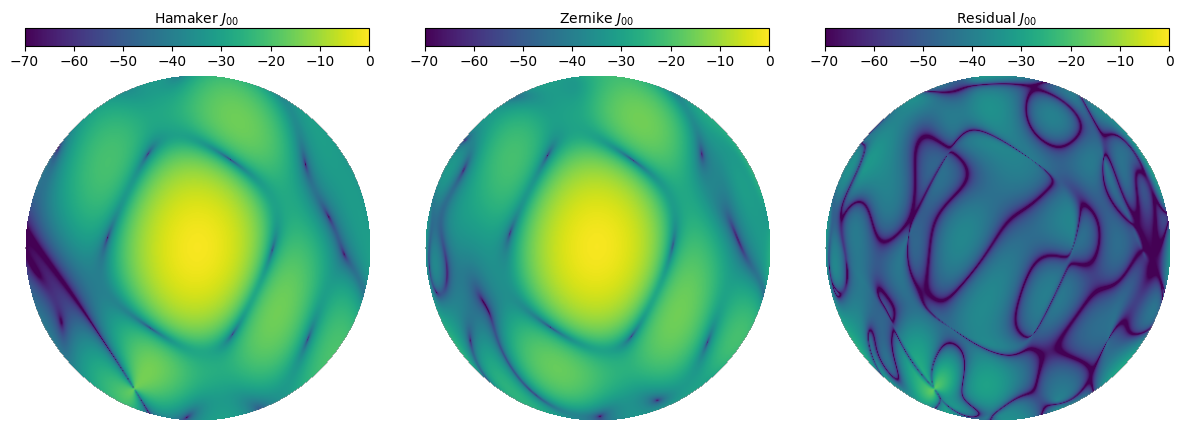

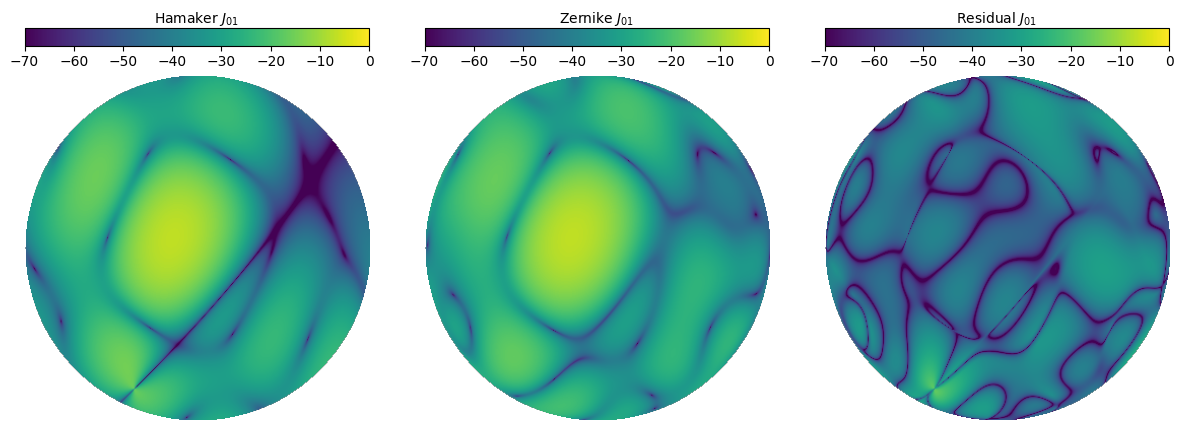

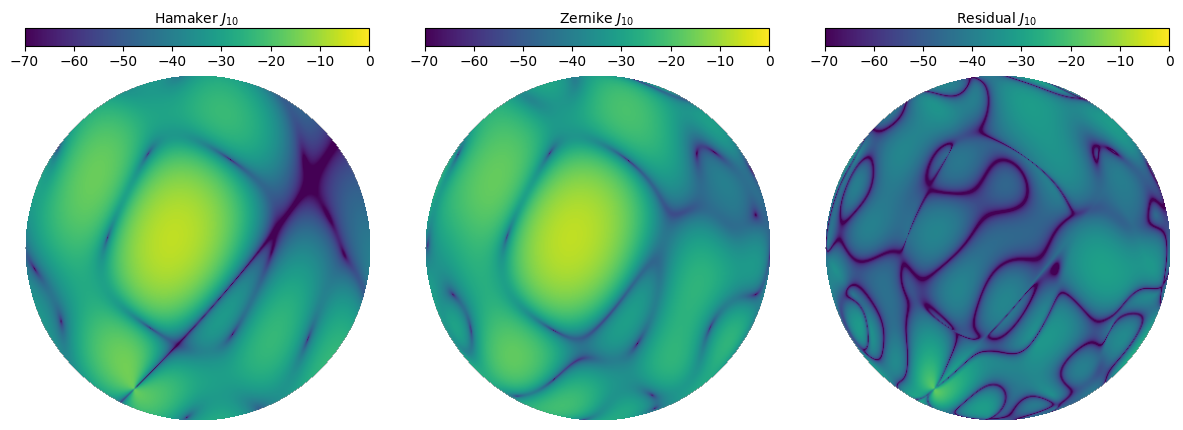

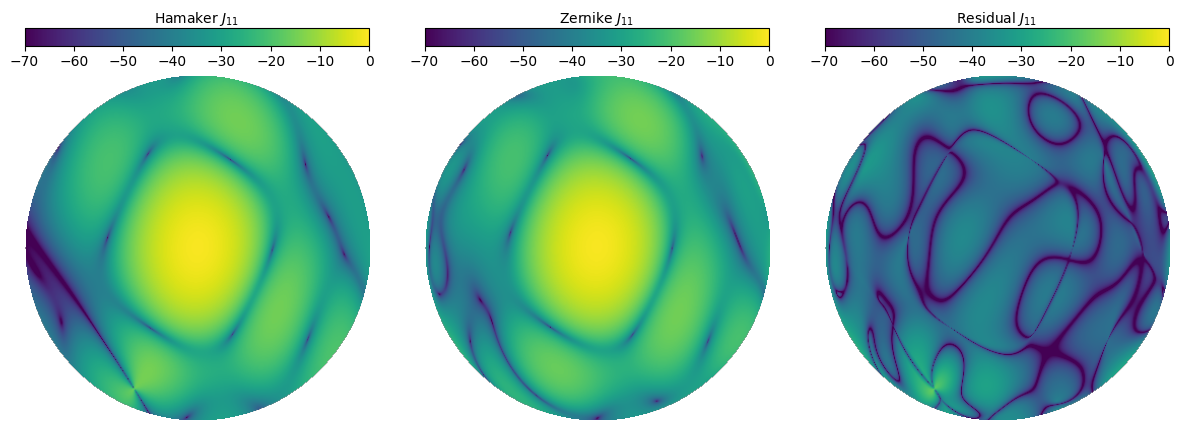

In [30]:
for i in range(2):
    for j in range(2):
        zernike_decom_recon(Jz[:,:,i,j], i,j, modes=200, thresh=20); 

# All frequencies

In [60]:
data_path = '/media/plato/lofar/beam/beam_all_freq_cropped.npy'
Jza = np.load(data_path) 


In [61]:
c = 169
r = 85
Jza_croped = Jza[:, c-r:c+r, c-r:c+r, 0,0]

In [62]:
def zernike_decom(data):
    modes=200
    Cr = zernike.decompose(data.real, modes)
    Ci = zernike.decompose(data.imag, modes)
    return Cr+1j+Ci


In [63]:
freqs = np.arange(110, 170) * 1e6
start_time = time.time()

j = 0
# Use 80% of available cores
coeffs = np.array(parallelize.parmap(zernike_decom, Jza_croped, proc_power=.8))

end_time = time.time()
print(f"Total execution time: {end_time - start_time:.2f} seconds")


Total execution time: 44.60 seconds


In [64]:
coeffs.shape

(61, 200)

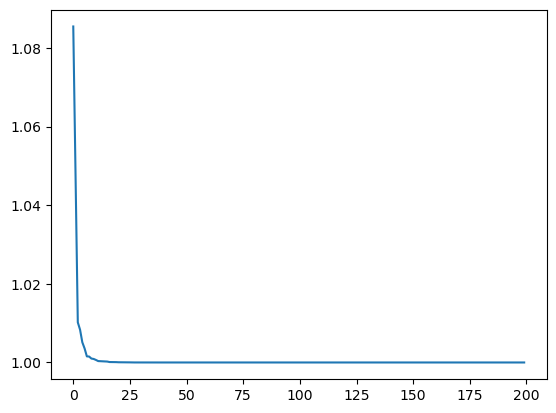

In [65]:
coeffs_avg = np.mean(coeffs, axis=0)
coeffs_avg.shape

sortind = np.argsort(np.abs(coeffs_avg))[::-1]

plt.plot(np.abs(coeffs_avg[sortind]))

In [66]:
sortind

array([  3,   0,  10,   5,  11,   1,   7,   8,   4,  13,  14,  23,   9,
        21,   2,  18,  12,  20,   6,  25,  16,  17,  15,  26,  27,  24,
        37,  30,  36,  28,  32,  39,  31,  34,  22,  35,  19,  43,  41,
        42,  33,  44,  40,  29,  48,  57,  49,  47,  46,  53,  55,  59,
        64,  54,  77,  52,  38,  51,  72,  74,  45,  63,  50,  89,  76,
        71,  90, 104,  85,  73,  60,  87,  58,  65,  69,  70, 119,  79,
        56,  68, 100,  83, 102,  66,  75,  84,  98,  78,  82, 134, 103,
       101, 135,  67, 116,  88, 152,  61,  81, 114,  99, 118, 115, 113,
        95, 133,  96, 117, 169, 131,  80,  97, 151, 150,  93, 111, 148,
       188, 128, 129, 189, 126, 112, 130, 168, 110, 146, 149, 108, 167,
        62, 165, 187, 166, 107, 163,  92, 143, 185, 170, 124, 145, 105,
       147, 106, 132, 125,  86, 144,  91, 182, 161, 141, 184, 186, 183,
       109, 123, 162, 180, 122, 164, 139, 160, 158, 190,  94, 140, 127,
       121, 154, 159, 120, 178, 142, 175, 194, 191, 138, 196, 19

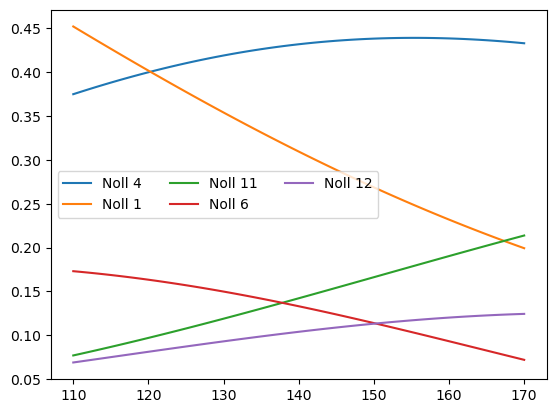

In [68]:
freqs = np.arange(110, 171)

for i in range(5):
    plt.plot(freqs, np.abs(coeffs[:,sortind[i]].real), label='Noll %i'%(sortind[i]+1))

plt.legend(ncol=3)


Text(0, 0.5, 'Imaginary coefficient energy')

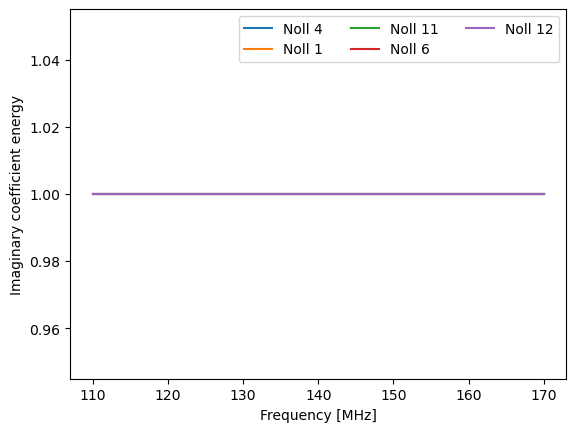

In [69]:
freqs = np.arange(110, 171)

for i in range(5):
    plt.plot(freqs, np.abs(coeffs[:,sortind[i]].imag), label='Noll %i'%(sortind[i]+1))

plt.legend(ncol=3)
plt.xlabel('Frequency [MHz]'); plt.ylabel('Imaginary coefficient energy')